<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/0728_Cabbage_predict_1day_base_LSTM_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import os
# past = lookback
past = 15
# dat = predict future day
day = 1

#LSTM unit
LSTM_unit = 512

# 選擇train/test 切割日期
train_date = "2020-06-01"
test_date = "2020-06-01"

# 選擇 train start 日期
choice_date = False
# choice_date = True
start_date = "2010-01-01"

# 選擇是否需要天氣
choice_w = False
# choice_w = True

# 驗證資料切割%數
val_split = 0.1

# 選擇是否加入 price/volums diff value data
# diff_value = False
diff_value = True

In [ ]:
if os.path.isfile("Cabbage_v2.xlsx") == True:
  pass
else:
  !wget "https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/Yi-Wei-Lin/dataset/Cabbage_v2.xlsx"

if os.path.isfile("reportdaily_mean_fillna.csv") == True:
  pass
else:
  !wget "https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/reportdaily_mean_fillna.csv"

if os.path.isfile("TyphoonDatabase.csv") == True:
  pass
else:
  !wget "https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/amoswu/dataset/TyphoonDatabase.csv"

--2021-07-28 08:45:20--  https://github.com/Yi-Wei-Lin/Tibame_AI_Project/raw/main/userdata/Yi-Wei-Lin/dataset/Cabbage_v2.xlsx
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Yi-Wei-Lin/Tibame_AI_Project/main/userdata/Yi-Wei-Lin/dataset/Cabbage_v2.xlsx [following]
--2021-07-28 08:45:20--  https://raw.githubusercontent.com/Yi-Wei-Lin/Tibame_AI_Project/main/userdata/Yi-Wei-Lin/dataset/Cabbage_v2.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6911422 (6.6M) [application/octet-stream]
Saving to: ‘Cabbage_v2.xlsx’

Cabbage_v2.xlsx     100%[===================>]   6.59M  29.3MB/s    in 0.2s    



In [ ]:
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}
df = pd.read_csv('reportdaily_mean_fillna.csv', encoding='utf-8')
# 使用index做merge
df_date = df['date'].drop_duplicates().to_frame().set_index('date')

for cityname, citycode in city.items():
    df_city = df.loc[df['city'] == cityname].add_suffix('_' + citycode).set_index('date' + '_' + citycode)
    df_date = pd.merge(df_date, df_city, how='left', left_index = True, right_index = True)

df_date.to_csv('all.csv', encoding='utf-8')
typhoon_df = pd.read_csv('TyphoonDatabase.csv', encoding='utf-8')
weather_df = pd.read_csv('all.csv', encoding='utf-8')
weather_df['WarnMark'] = 0
# 警報日期處理
import datetime

period_ctrl = 0 # 颱風警報期間控制
warn_mark = list()

for wd in typhoon_df['Warning']:
  start = datetime.datetime.strptime(wd[0:10], '%Y-%m-%d')
  end = datetime.datetime.strptime(wd[17:27], '%Y-%m-%d')
  period = end - start
  # print(period.days)
  
  ctrl_start = start
  i = 0
  
  warn_mark.append(wd[0:10])
  while i < period.days:
    start = start + datetime.timedelta(days=1)
    warn_mark.append(datetime.datetime.strftime(start, '%Y-%m-%d'))
    i = i + 1
  warn_mark.append(wd[17:27])

  if period_ctrl != 0:
    j = 0
    while j < period_ctrl:
      ctrl_start = ctrl_start - datetime.timedelta(days=1)
      warn_mark.append(datetime.datetime.strftime(ctrl_start, '%Y-%m-%d'))
      j = j + 1

unique_set = set(warn_mark)
unique_list = list(unique_set)
warn_mark = list()
warn_mark = unique_list
import csv

weather_list = weather_df.values.tolist()

with open('dataset.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)
  
  writer.writerow(['date','city_KLU','StnPres_KLU','SeaPres_KLU','StnPresMax_KLU','StnPresMaxTime_KLU','StnPresMin_KLU','StnPresMinTime_KLU','Temperature_KLU','TMax_KLU','TMaxTime_KLU','TMin_KLU','TMinTime_KLU','TdDewPoint_KLU','RH_KLU','RHMin_KLU','RHMinTime_KLU','WS_KLU','WD_KLU','WSGust_KLU','WDGust_KLU','WGustTime_KLU','Precp_KLU','PrecpHour_KLU','PrecpMax10_KLU','PrecpMax10Time_KLU','PrecpMax60_KLU','PrecpMax60Time_KLU','SunShine_KLU','SunShineRate_KLU','GloblRad_KLU','VisbMean_KLU','EvapA_KLU','UVIMax_KLU','UVIMaxTime_KLU','CloudAmount_KLU','city_TPE','StnPres_TPE','SeaPres_TPE','StnPresMax_TPE','StnPresMaxTime_TPE','StnPresMin_TPE','StnPresMinTime_TPE','Temperature_TPE','TMax_TPE','TMaxTime_TPE','TMin_TPE','TMinTime_TPE','TdDewPoint_TPE','RH_TPE','RHMin_TPE','RHMinTime_TPE','WS_TPE','WD_TPE','WSGust_TPE','WDGust_TPE','WGustTime_TPE','Precp_TPE','PrecpHour_TPE','PrecpMax10_TPE','PrecpMax10Time_TPE','PrecpMax60_TPE','PrecpMax60Time_TPE','SunShine_TPE','SunShineRate_TPE','GloblRad_TPE','VisbMean_TPE','EvapA_TPE','UVIMax_TPE','UVIMaxTime_TPE','CloudAmount_TPE','city_TPH','StnPres_TPH','SeaPres_TPH','StnPresMax_TPH','StnPresMaxTime_TPH','StnPresMin_TPH','StnPresMinTime_TPH','Temperature_TPH','TMax_TPH','TMaxTime_TPH','TMin_TPH','TMinTime_TPH','TdDewPoint_TPH','RH_TPH','RHMin_TPH','RHMinTime_TPH','WS_TPH','WD_TPH','WSGust_TPH','WDGust_TPH','WGustTime_TPH','Precp_TPH','PrecpHour_TPH','PrecpMax10_TPH','PrecpMax10Time_TPH','PrecpMax60_TPH','PrecpMax60Time_TPH','SunShine_TPH','SunShineRate_TPH','GloblRad_TPH','VisbMean_TPH','EvapA_TPH','UVIMax_TPH','UVIMaxTime_TPH','CloudAmount_TPH','city_TYC','StnPres_TYC','SeaPres_TYC','StnPresMax_TYC','StnPresMaxTime_TYC','StnPresMin_TYC','StnPresMinTime_TYC','Temperature_TYC','TMax_TYC','TMaxTime_TYC','TMin_TYC','TMinTime_TYC','TdDewPoint_TYC','RH_TYC','RHMin_TYC','RHMinTime_TYC','WS_TYC','WD_TYC','WSGust_TYC','WDGust_TYC','WGustTime_TYC','Precp_TYC','PrecpHour_TYC','PrecpMax10_TYC','PrecpMax10Time_TYC','PrecpMax60_TYC','PrecpMax60Time_TYC','SunShine_TYC','SunShineRate_TYC','GloblRad_TYC','VisbMean_TYC','EvapA_TYC','UVIMax_TYC','UVIMaxTime_TYC','CloudAmount_TYC','city_HSC','StnPres_HSC','SeaPres_HSC','StnPresMax_HSC','StnPresMaxTime_HSC','StnPresMin_HSC','StnPresMinTime_HSC','Temperature_HSC','TMax_HSC','TMaxTime_HSC','TMin_HSC','TMinTime_HSC','TdDewPoint_HSC','RH_HSC','RHMin_HSC','RHMinTime_HSC','WS_HSC','WD_HSC','WSGust_HSC','WDGust_HSC','WGustTime_HSC','Precp_HSC','PrecpHour_HSC','PrecpMax10_HSC','PrecpMax10Time_HSC','PrecpMax60_HSC','PrecpMax60Time_HSC','SunShine_HSC','SunShineRate_HSC','GloblRad_HSC','VisbMean_HSC','EvapA_HSC','UVIMax_HSC','UVIMaxTime_HSC','CloudAmount_HSC','city_HSH','StnPres_HSH','SeaPres_HSH','StnPresMax_HSH','StnPresMaxTime_HSH','StnPresMin_HSH','StnPresMinTime_HSH','Temperature_HSH','TMax_HSH','TMaxTime_HSH','TMin_HSH','TMinTime_HSH','TdDewPoint_HSH','RH_HSH','RHMin_HSH','RHMinTime_HSH','WS_HSH','WD_HSH','WSGust_HSH','WDGust_HSH','WGustTime_HSH','Precp_HSH','PrecpHour_HSH','PrecpMax10_HSH','PrecpMax10Time_HSH','PrecpMax60_HSH','PrecpMax60Time_HSH','SunShine_HSH','SunShineRate_HSH','GloblRad_HSH','VisbMean_HSH','EvapA_HSH','UVIMax_HSH','UVIMaxTime_HSH','CloudAmount_HSH','city_MAL','StnPres_MAL','SeaPres_MAL','StnPresMax_MAL','StnPresMaxTime_MAL','StnPresMin_MAL','StnPresMinTime_MAL','Temperature_MAL','TMax_MAL','TMaxTime_MAL','TMin_MAL','TMinTime_MAL','TdDewPoint_MAL','RH_MAL','RHMin_MAL','RHMinTime_MAL','WS_MAL','WD_MAL','WSGust_MAL','WDGust_MAL','WGustTime_MAL','Precp_MAL','PrecpHour_MAL','PrecpMax10_MAL','PrecpMax10Time_MAL','PrecpMax60_MAL','PrecpMax60Time_MAL','SunShine_MAL','SunShineRate_MAL','GloblRad_MAL','VisbMean_MAL','EvapA_MAL','UVIMax_MAL','UVIMaxTime_MAL','CloudAmount_MAL','city_TXG','StnPres_TXG','SeaPres_TXG','StnPresMax_TXG','StnPresMaxTime_TXG','StnPresMin_TXG','StnPresMinTime_TXG','Temperature_TXG','TMax_TXG','TMaxTime_TXG','TMin_TXG','TMinTime_TXG','TdDewPoint_TXG','RH_TXG','RHMin_TXG','RHMinTime_TXG','WS_TXG','WD_TXG','WSGust_TXG','WDGust_TXG','WGustTime_TXG','Precp_TXG','PrecpHour_TXG','PrecpMax10_TXG','PrecpMax10Time_TXG','PrecpMax60_TXG','PrecpMax60Time_TXG','SunShine_TXG','SunShineRate_TXG','GloblRad_TXG','VisbMean_TXG','EvapA_TXG','UVIMax_TXG','UVIMaxTime_TXG','CloudAmount_TXG','city_CWH','StnPres_CWH','SeaPres_CWH','StnPresMax_CWH','StnPresMaxTime_CWH','StnPresMin_CWH','StnPresMinTime_CWH','Temperature_CWH','TMax_CWH','TMaxTime_CWH','TMin_CWH','TMinTime_CWH','TdDewPoint_CWH','RH_CWH','RHMin_CWH','RHMinTime_CWH','WS_CWH','WD_CWH','WSGust_CWH','WDGust_CWH','WGustTime_CWH','Precp_CWH','PrecpHour_CWH','PrecpMax10_CWH','PrecpMax10Time_CWH','PrecpMax60_CWH','PrecpMax60Time_CWH','SunShine_CWH','SunShineRate_CWH','GloblRad_CWH','VisbMean_CWH','EvapA_CWH','UVIMax_CWH','UVIMaxTime_CWH','CloudAmount_CWH','city_NTO','StnPres_NTO','SeaPres_NTO','StnPresMax_NTO','StnPresMaxTime_NTO','StnPresMin_NTO','StnPresMinTime_NTO','Temperature_NTO','TMax_NTO','TMaxTime_NTO','TMin_NTO','TMinTime_NTO','TdDewPoint_NTO','RH_NTO','RHMin_NTO','RHMinTime_NTO','WS_NTO','WD_NTO','WSGust_NTO','WDGust_NTO','WGustTime_NTO','Precp_NTO','PrecpHour_NTO','PrecpMax10_NTO','PrecpMax10Time_NTO','PrecpMax60_NTO','PrecpMax60Time_NTO','SunShine_NTO','SunShineRate_NTO','GloblRad_NTO','VisbMean_NTO','EvapA_NTO','UVIMax_NTO','UVIMaxTime_NTO','CloudAmount_NTO','city_YLH','StnPres_YLH','SeaPres_YLH','StnPresMax_YLH','StnPresMaxTime_YLH','StnPresMin_YLH','StnPresMinTime_YLH','Temperature_YLH','TMax_YLH','TMaxTime_YLH','TMin_YLH','TMinTime_YLH','TdDewPoint_YLH','RH_YLH','RHMin_YLH','RHMinTime_YLH','WS_YLH','WD_YLH','WSGust_YLH','WDGust_YLH','WGustTime_YLH','Precp_YLH','PrecpHour_YLH','PrecpMax10_YLH','PrecpMax10Time_YLH','PrecpMax60_YLH','PrecpMax60Time_YLH','SunShine_YLH','SunShineRate_YLH','GloblRad_YLH','VisbMean_YLH','EvapA_YLH','UVIMax_YLH','UVIMaxTime_YLH','CloudAmount_YLH','city_CYI','StnPres_CYI','SeaPres_CYI','StnPresMax_CYI','StnPresMaxTime_CYI','StnPresMin_CYI','StnPresMinTime_CYI','Temperature_CYI','TMax_CYI','TMaxTime_CYI','TMin_CYI','TMinTime_CYI','TdDewPoint_CYI','RH_CYI','RHMin_CYI','RHMinTime_CYI','WS_CYI','WD_CYI','WSGust_CYI','WDGust_CYI','WGustTime_CYI','Precp_CYI','PrecpHour_CYI','PrecpMax10_CYI','PrecpMax10Time_CYI','PrecpMax60_CYI','PrecpMax60Time_CYI','SunShine_CYI','SunShineRate_CYI','GloblRad_CYI','VisbMean_CYI','EvapA_CYI','UVIMax_CYI','UVIMaxTime_CYI','CloudAmount_CYI','city_CHY','StnPres_CHY','SeaPres_CHY','StnPresMax_CHY','StnPresMaxTime_CHY','StnPresMin_CHY','StnPresMinTime_CHY','Temperature_CHY','TMax_CHY','TMaxTime_CHY','TMin_CHY','TMinTime_CHY','TdDewPoint_CHY','RH_CHY','RHMin_CHY','RHMinTime_CHY','WS_CHY','WD_CHY','WSGust_CHY','WDGust_CHY','WGustTime_CHY','Precp_CHY','PrecpHour_CHY','PrecpMax10_CHY','PrecpMax10Time_CHY','PrecpMax60_CHY','PrecpMax60Time_CHY','SunShine_CHY','SunShineRate_CHY','GloblRad_CHY','VisbMean_CHY','EvapA_CHY','UVIMax_CHY','UVIMaxTime_CHY','CloudAmount_CHY','city_TNN','StnPres_TNN','SeaPres_TNN','StnPresMax_TNN','StnPresMaxTime_TNN','StnPresMin_TNN','StnPresMinTime_TNN','Temperature_TNN','TMax_TNN','TMaxTime_TNN','TMin_TNN','TMinTime_TNN','TdDewPoint_TNN','RH_TNN','RHMin_TNN','RHMinTime_TNN','WS_TNN','WD_TNN','WSGust_TNN','WDGust_TNN','WGustTime_TNN','Precp_TNN','PrecpHour_TNN','PrecpMax10_TNN','PrecpMax10Time_TNN','PrecpMax60_TNN','PrecpMax60Time_TNN','SunShine_TNN','SunShineRate_TNN','GloblRad_TNN','VisbMean_TNN','EvapA_TNN','UVIMax_TNN','UVIMaxTime_TNN','CloudAmount_TNN','city_KHH','StnPres_KHH','SeaPres_KHH','StnPresMax_KHH','StnPresMaxTime_KHH','StnPresMin_KHH','StnPresMinTime_KHH','Temperature_KHH','TMax_KHH','TMaxTime_KHH','TMin_KHH','TMinTime_KHH','TdDewPoint_KHH','RH_KHH','RHMin_KHH','RHMinTime_KHH','WS_KHH','WD_KHH','WSGust_KHH','WDGust_KHH','WGustTime_KHH','Precp_KHH','PrecpHour_KHH','PrecpMax10_KHH','PrecpMax10Time_KHH','PrecpMax60_KHH','PrecpMax60Time_KHH','SunShine_KHH','SunShineRate_KHH','GloblRad_KHH','VisbMean_KHH','EvapA_KHH','UVIMax_KHH','UVIMaxTime_KHH','CloudAmount_KHH','city_IUH','StnPres_IUH','SeaPres_IUH','StnPresMax_IUH','StnPresMaxTime_IUH','StnPresMin_IUH','StnPresMinTime_IUH','Temperature_IUH','TMax_IUH','TMaxTime_IUH','TMin_IUH','TMinTime_IUH','TdDewPoint_IUH','RH_IUH','RHMin_IUH','RHMinTime_IUH','WS_IUH','WD_IUH','WSGust_IUH','WDGust_IUH','WGustTime_IUH','Precp_IUH','PrecpHour_IUH','PrecpMax10_IUH','PrecpMax10Time_IUH','PrecpMax60_IUH','PrecpMax60Time_IUH','SunShine_IUH','SunShineRate_IUH','GloblRad_IUH','VisbMean_IUH','EvapA_IUH','UVIMax_IUH','UVIMaxTime_IUH','CloudAmount_IUH','city_ILN','StnPres_ILN','SeaPres_ILN','StnPresMax_ILN','StnPresMaxTime_ILN','StnPresMin_ILN','StnPresMinTime_ILN','Temperature_ILN','TMax_ILN','TMaxTime_ILN','TMin_ILN','TMinTime_ILN','TdDewPoint_ILN','RH_ILN','RHMin_ILN','RHMinTime_ILN','WS_ILN','WD_ILN','WSGust_ILN','WDGust_ILN','WGustTime_ILN','Precp_ILN','PrecpHour_ILN','PrecpMax10_ILN','PrecpMax10Time_ILN','PrecpMax60_ILN','PrecpMax60Time_ILN','SunShine_ILN','SunShineRate_ILN','GloblRad_ILN','VisbMean_ILN','EvapA_ILN','UVIMax_ILN','UVIMaxTime_ILN','CloudAmount_ILN','city_HWA','StnPres_HWA','SeaPres_HWA','StnPresMax_HWA','StnPresMaxTime_HWA','StnPresMin_HWA','StnPresMinTime_HWA','Temperature_HWA','TMax_HWA','TMaxTime_HWA','TMin_HWA','TMinTime_HWA','TdDewPoint_HWA','RH_HWA','RHMin_HWA','RHMinTime_HWA','WS_HWA','WD_HWA','WSGust_HWA','WDGust_HWA','WGustTime_HWA','Precp_HWA','PrecpHour_HWA','PrecpMax10_HWA','PrecpMax10Time_HWA','PrecpMax60_HWA','PrecpMax60Time_HWA','SunShine_HWA','SunShineRate_HWA','GloblRad_HWA','VisbMean_HWA','EvapA_HWA','UVIMax_HWA','UVIMaxTime_HWA','CloudAmount_HWA','city_TTT','StnPres_TTT','SeaPres_TTT','StnPresMax_TTT','StnPresMaxTime_TTT','StnPresMin_TTT','StnPresMinTime_TTT','Temperature_TTT','TMax_TTT','TMaxTime_TTT','TMin_TTT','TMinTime_TTT','TdDewPoint_TTT','RH_TTT','RHMin_TTT','RHMinTime_TTT','WS_TTT','WD_TTT','WSGust_TTT','WDGust_TTT','WGustTime_TTT','Precp_TTT','PrecpHour_TTT','PrecpMax10_TTT','PrecpMax10Time_TTT','PrecpMax60_TTT','PrecpMax60Time_TTT','SunShine_TTT','SunShineRate_TTT','GloblRad_TTT','VisbMean_TTT','EvapA_TTT','UVIMax_TTT','UVIMaxTime_TTT','CloudAmount_TTT','WarnMark'])

  for wl in weather_list:
    f = 0
    for wm in warn_mark:
      if wl[0] == wm:
        wl[666] = 1
        writer.writerow(wl)
        f = 1
    if f == 0:
      writer.writerow(wl)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data = pd.read_excel("Cabbage_v2.xlsx")
data_w = pd.read_csv("dataset.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
if diff_value == True:
  data["Avg_price_diff"] = data["Avg_price_diff"].fillna(0)
  data["Volume_diff"] = data["Volume_diff"].fillna(0)
else:
  data = data.drop(["Avg_price_diff"], axis=1)
  data = data.drop(["Volume_diff"], axis=1)

In [ ]:
drop_name = ["city_", "StnPresMaxTime_", "StnPresMinTime_", "TMaxTime_", "TMinTime_", "RHMinTime_", "WGustTime_", "PrecpMax10Time_", "PrecpMax60Time_", "UVIMaxTime_"]
city = [
    'KLU',
    'TPE',
    'TPH',
    'TYC',
    'HSC',
    'HSH',
    'MAL',
    'TXG',
    'CWH',
    'NTO',
    'YLH',
    'CYI',
    'CHY',
    'TNN',
    'KHH',
    'IUH',
    'ILN',
    'HWA',
    'TTT'
]
drop = []
for c in city:
  for n in drop_name:
    drop.append(n+c)
data_w = data_w.drop(drop, axis=1).dropna()
data_w = data_w.rename(columns={'date':'Date'})
data_w["Date"] = pd.to_datetime(data_w["Date"])

In [ ]:
data = data.dropna()
data = data.loc[data["Market"] == "台北一"]
np.array(data["Avg_price"]).reshape(-1,1)

array([[ 8.9],
       [ 7.2],
       [ 6.7],
       ...,
       [15.1],
       [15.1],
       [15.5]])

In [ ]:
if choice_w == True:
  data = pd.merge(data,data_w,how="left", on="Date").dropna()

In [ ]:
data = data.reset_index()
data

,index,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month,Week_day,Year,Rest_day
0,39204,2000-01-02,台北一,LA1 甘藍 初秋,11.0,8.0,5.0,8.9,0.00,192029.0,0.00,1,7,2000,0
1,39205,2000-01-03,台北一,LA1 甘藍 初秋,9.0,7.0,4.0,7.2,-19.10,174270.0,-9.25,1,1,2000,0
2,39206,2000-01-04,台北一,LA1 甘藍 初秋,8.0,6.0,3.0,6.7,-6.94,125426.0,-28.03,1,2,2000,0
3,39207,2000-01-05,台北一,LA1 甘藍 初秋,10.0,7.0,4.0,7.1,5.97,119318.0,-4.87,1,3,2000,0
4,39208,2000-01-06,台北一,LA1 甘藍 初秋,9.0,7.0,5.0,6.8,-4.23,118178.0,-0.96,1,4,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6497,47037,2021-06-13,台北一,LA1 甘藍 初秋,23.0,15.6,6.2,15.2,2.70,174973.0,-9.22,6,7,2021,0
6498,47038,2021-06-14,台北一,LA1 甘藍 初秋,27.4,21.4,13.6,21.0,38.16,128693.0,-26.45,6,1,2021,0
6499,47041,2021-06-17,台北一,LA1 甘藍 初秋,21.8,15.0,8.5,15.1,-28.10,96289.0,-25.18,6,4,2021,0
6500,47042,2021-06-18,台北一,LA1 甘藍 初秋,21.9,15.2,8.1,15.1,0.00,148701.0,54.43,6,5,2021,0


In [ ]:
# data_dum = pd.get_dummies(data)
# pd.DataFrame(data_dum)
from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()
data_str_ohe=onehotencoder.fit_transform(data[["Month"]]).toarray()
month = pd.DataFrame(data_str_ohe)
for i in month:
  new = int(i) + 1
  new = str(new)
  month = month.rename(columns={i:new})
month = month.add_prefix("Month_")
data = data.join(month, how="left")
# df.loc[df['city'] == '基隆市'].add_suffix('_' + 'KLU')
# df.rename(columns={'舊欄位名稱': '新欄位名稱'}) .add_prefix("Month_")

In [ ]:
onehotencoder = OneHotEncoder()
data_str_ohe=onehotencoder.fit_transform(data[["Week_day"]]).toarray()
month = pd.DataFrame(data_str_ohe)
for i in month:
  new = int(i) + 1
  new = str(new)
  month = month.rename(columns={i:new})
month = month.add_prefix("Week_day_")
data = data.join(month, how="left")

In [ ]:
# onehotencoder = OneHotEncoder()
# data_str_ohe=onehotencoder.fit_transform(data[["Year"]]).toarray()
# month = pd.DataFrame(data_str_ohe)
# for i in month:
#   new = int(i) + data["Year"].iloc[0]
#   new = str(new)
#   month = month.rename(columns={i:new})
# month = month.add_prefix("Year_")
# data = data.join(month, how="left")

In [ ]:
data_train = data[data["Date"] < "2020-06-01"]
if choice_date == True:
  data_train = data_train[data_train["Date"] > start_date]
data_test = data[data["Date"] >= "2020-06-01"]

In [ ]:
data[data["Date"] >= "2020-06-01"].head(10)

,index,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month,Week_day,Year,Rest_day,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_day_1,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7
6194,46661,2020-06-02,台北一,LA1 甘藍 初秋,22.7,17.3,12.1,17.4,-6.95,226374.0,9.88,6,2,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6195,46662,2020-06-03,台北一,LA1 甘藍 初秋,23.4,16.7,9.4,16.6,-4.60,181927.0,-19.63,6,3,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6196,46663,2020-06-04,台北一,LA1 甘藍 初秋,21.7,14.7,8.2,14.8,-10.84,187080.0,2.83,6,4,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6197,46664,2020-06-05,台北一,LA1 甘藍 初秋,20.9,15.5,11.0,15.7,6.08,153694.0,-17.85,6,5,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6198,46665,2020-06-06,台北一,LA1 甘藍 初秋,20.9,15.1,9.0,15.1,-3.82,192696.0,25.38,6,6,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6199,46666,2020-06-07,台北一,LA1 甘藍 初秋,22.4,16.5,9.3,16.2,7.28,163655.0,-15.07,6,7,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6200,46668,2020-06-09,台北一,LA1 甘藍 初秋,25.9,20.9,12.8,20.3,25.31,130241.0,-20.42,6,2,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6201,46669,2020-06-10,台北一,LA1 甘藍 初秋,25.3,20.9,12.9,20.2,-0.49,130421.0,0.14,6,3,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6202,46670,2020-06-11,台北一,LA1 甘藍 初秋,23.3,18.4,9.0,17.5,-13.37,174454.0,33.76,6,4,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6203,46671,2020-06-12,台北一,LA1 甘藍 初秋,23.9,18.5,10.9,18.0,2.86,148541.0,-14.85,6,5,2020,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
data_train

,index,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month,Week_day,Year,Rest_day,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_day_1,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7
0,39204,2000-01-02,台北一,LA1 甘藍 初秋,11.0,8.0,5.0,8.9,0.00,192029.0,0.00,1,7,2000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,39205,2000-01-03,台北一,LA1 甘藍 初秋,9.0,7.0,4.0,7.2,-19.10,174270.0,-9.25,1,1,2000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39206,2000-01-04,台北一,LA1 甘藍 初秋,8.0,6.0,3.0,6.7,-6.94,125426.0,-28.03,1,2,2000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,39207,2000-01-05,台北一,LA1 甘藍 初秋,10.0,7.0,4.0,7.1,5.97,119318.0,-4.87,1,3,2000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,39208,2000-01-06,台北一,LA1 甘藍 初秋,9.0,7.0,5.0,6.8,-4.23,118178.0,-0.96,1,4,2000,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6189,46655,2020-05-27,台北一,LA1 甘藍 初秋,25.7,16.3,8.7,16.7,-10.70,172209.0,-2.96,5,3,2020,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6190,46656,2020-05-28,台北一,LA1 甘藍 初秋,22.1,15.9,10.9,16.2,-2.99,139310.0,-19.10,5,4,2020,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6191,46657,2020-05-29,台北一,LA1 甘藍 初秋,22.8,18.0,12.1,17.8,9.88,135844.0,-2.49,5,5,2020,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6192,46658,2020-05-30,台北一,LA1 甘藍 初秋,26.3,18.2,11.5,18.5,3.93,183403.0,35.01,5,6,2020,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
data_train = data_train.drop(["index", "Date","Market", "Product", "Rest_day", "Year", "Month", "Week_day"], axis=1)
data_test = data_test.drop(["index", "Date","Market", "Product", "Rest_day", "Year", "Month", "Week_day"], axis=1)
data_train

,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_day_1,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7
0,11.0,8.0,5.0,8.9,0.00,192029.0,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.0,7.0,4.0,7.2,-19.10,174270.0,-9.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8.0,6.0,3.0,6.7,-6.94,125426.0,-28.03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10.0,7.0,4.0,7.1,5.97,119318.0,-4.87,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,9.0,7.0,5.0,6.8,-4.23,118178.0,-0.96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6189,25.7,16.3,8.7,16.7,-10.70,172209.0,-2.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6190,22.1,15.9,10.9,16.2,-2.99,139310.0,-19.10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6191,22.8,18.0,12.1,17.8,9.88,135844.0,-2.49,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6192,26.3,18.2,11.5,18.5,3.93,183403.0,35.01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# from tensorflow.keras.utils import to_categorical
# pd.DataFrame(to_categorical(data_train["Month"]))
feature = data_train.shape[1]
print(feature)

26


In [ ]:
len_data = len(data_train)
len_train = int(len_data*(1-val_split))
len_val = (len_data-len_train)

In [ ]:
print(len_data)
print(len_train)
print(len_val)
print(len_train + len_val)
data_val = data_train[len_train:]
data_train = data_train[0:len_train]
data_val_past = data_val.tail(past+day-1)

6194
5574
620
6194


In [ ]:
data_test = data_val_past.append(data_test)
data_test

,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Week_day_1,Week_day_2,Week_day_3,Week_day_4,Week_day_5,Week_day_6,Week_day_7
6179,18.7,14.6,11.0,14.7,1.38,152475.0,8.80,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6180,18.5,15.1,10.8,14.9,1.36,164298.0,7.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6181,18.5,14.3,11.0,14.5,-2.68,171272.0,4.24,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6182,17.9,15.1,10.8,14.8,2.07,185647.0,8.39,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6183,18.6,16.0,13.1,15.9,7.43,144488.0,-22.17,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6497,23.0,15.6,6.2,15.2,2.70,174973.0,-9.22,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6498,27.4,21.4,13.6,21.0,38.16,128693.0,-26.45,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6499,21.8,15.0,8.5,15.1,-28.10,96289.0,-25.18,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6500,21.9,15.2,8.1,15.1,0.00,148701.0,54.43,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# preparing label data
Cabbage_shift = data_train.shift(-day)
label = Cabbage_shift['Avg_price']

# adjusting the shape of both
data_train = data_train.drop(data_train.index[len(data_train)-day:], axis=0)
label = label.drop(label.index[len(label)-day:], axis=0)

# conversion to numpy array
x, y = data_train.values, label.values

In [ ]:
# preparing label data
Cabbage_shift = data_val.shift(-day)
label = Cabbage_shift['Avg_price']

# adjusting the shape of both
data_val = data_val.drop(data_val.index[len(data_val)-day:], axis=0)
label = label.drop(label.index[len(label)-day:], axis=0)

# conversion to numpy array
x_val, y_val = data_val.values, label.values

In [ ]:
# Cabbage_shift = data_test.shift(-day)
label = data_test['Avg_price']

# adjusting the shape of both
# data_test = data_test.drop(data_test.index[len(data_test)-day:], axis=0)
# label = label.drop(label.index[len(label)-day:], axis=0)


# conversion to numpy array
gg, yy = data_test.values, label.values

In [ ]:
X = []
for i in range(len(data_train)-past-day+1):
  xx = []
  for d in range(past):
    xx.append(data_train.iloc[i+d])
  X.append(xx)
X = np.array(X)
x_train = X
y_train = y[past-1:-day]

In [ ]:
X = []
for i in range(len(data_val)-past-day+1):
  xx = []
  for d in range(past):
    xx.append(data_val.iloc[i+d])
  X.append(xx)
X = np.array(X)
x_val = X
y_val = y_val[past-1:-day]
y_real = y_val

In [ ]:
X = []
for i in range(len(data_test)-past-day+1):
  xx = []
  for d in range(past):
    xx.append(data_test.iloc[i+d])
  X.append(xx)
X = np.array(X)
gg = X
yy = yy[past+day-1:]


In [ ]:
print(gg.shape)
gg

(308, 15, 26)


array([[[18.7, 14.6, 11. , ...,  1. ,  0. ,  0. ],
        [18.5, 15.1, 10.8, ...,  0. ,  1. ,  0. ],
        [18.5, 14.3, 11. , ...,  0. ,  0. ,  1. ],
        ...,
        [22.8, 18. , 12.1, ...,  1. ,  0. ,  0. ],
        [26.3, 18.2, 11.5, ...,  0. ,  1. ,  0. ],
        [25.1, 18.7, 12.1, ...,  0. ,  0. ,  1. ]],

       [[18.5, 15.1, 10.8, ...,  0. ,  1. ,  0. ],
        [18.5, 14.3, 11. , ...,  0. ,  0. ,  1. ],
        [17.9, 15.1, 10.8, ...,  0. ,  0. ,  0. ],
        ...,
        [26.3, 18.2, 11.5, ...,  0. ,  1. ,  0. ],
        [25.1, 18.7, 12.1, ...,  0. ,  0. ,  1. ],
        [22.7, 17.3, 12.1, ...,  0. ,  0. ,  0. ]],

       [[18.5, 14.3, 11. , ...,  0. ,  0. ,  1. ],
        [17.9, 15.1, 10.8, ...,  0. ,  0. ,  0. ],
        [18.6, 16. , 13.1, ...,  0. ,  0. ,  0. ],
        ...,
        [25.1, 18.7, 12.1, ...,  0. ,  0. ,  1. ],
        [22.7, 17.3, 12.1, ...,  0. ,  0. ,  0. ],
        [23.4, 16.7,  9.4, ...,  0. ,  0. ,  0. ]],

       ...,

       [[29.8, 22.5, 17.

In [ ]:
print(yy.shape)
yy

(308,)


array([17.4, 16.6, 14.8, 15.7, 15.1, 16.2, 20.3, 20.2, 17.5, 18. , 24.9,
       25.3, 28.7, 26. , 28.6, 29.7, 29. , 29. , 36.1, 38.9, 40. , 37.7,
       32. , 31.1, 32.9, 32.4, 24.6, 28.2, 28. , 26.4, 23. , 24.3, 27.1,
       25.4, 24.5, 25.5, 22. , 21.1, 21. , 22.2, 25.6, 24.7, 26.6, 22.9,
       25.5, 26.2, 23.5, 23.2, 26.7, 23.6, 26.7, 28.7, 33.2, 29.9, 30.7,
       27.6, 31.6, 37.8, 35. , 31.3, 30.4, 31.1, 32.7, 33.5, 31. , 35.4,
       36.9, 38.9, 41.5, 35.8, 35.2, 30.5, 33.9, 30.6, 39.9, 49.4, 36.4,
       29.7, 30.7, 31.9, 36.2, 31.5, 35.3, 31.7, 26.9, 24.6, 33.5, 31.5,
       30.2, 30.4, 30.6, 26.8, 28. , 27.4, 37. , 30.2, 28. , 32.3, 35.7,
       31.7, 29.5, 29. , 31.3, 33.5, 35. , 33.6, 27.9, 32.9, 36.3, 40.7,
       39.6, 39.1, 37.7, 38.1, 37.5, 43.2, 38.2, 33.4, 29.8, 31.5, 36.5,
       31.4, 32.8, 31.2, 29.6, 31.6, 28.9, 29.8, 29.4, 26.7, 31.7, 26. ,
       27.2, 21. , 17.1, 17.6, 16.3, 15.5, 15.4, 15.5, 18.3, 16.4, 14.2,
       16.1, 17.7, 18.4, 16.4, 15.8, 16.5, 16.6, 17

In [ ]:
x_shape = x_train.shape[0]
x_val_shape = x_val.shape[0]
x_train = x_train.reshape(-1,feature)
x_val = x_val.reshape(-1,feature)

In [ ]:
Xscaler = MinMaxScaler()
Yscaler = MinMaxScaler()
x_train = Xscaler.fit_transform(x_train)
y_train = Yscaler.fit_transform(y_train.reshape(-1,1))
x_val = Xscaler.transform(x_val)
y_val = Yscaler.transform(y_val.reshape(-1,1))

In [ ]:
x_train.shape

(83370, 26)

In [ ]:
# splitting train and test
# x_train = x_train.reshape((-1,1,5))
x_train = x_train.reshape((-1,past,feature))
x_val = x_val.reshape((-1,past,feature))

In [ ]:
# Building LSTM model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, BatchNormalization,Bidirectional
forword = LSTM(units=32, return_sequences=True)
backword = LSTM(units=32, return_sequences=True, go_backwards=True)
forword1 = LSTM(units=64, return_sequences=True)
backword1 = LSTM(units=64, return_sequences=True, go_backwards=True)
forword2 = LSTM(units=128, return_sequences=True)
backword2 = LSTM(units=128, return_sequences=True, go_backwards=True)           
layers = [
    # Bidirectional(forword, backward_layer=backword, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dropout(0.2),
    # Bidirectional(LSTM(units=64, return_sequences=True, go_backwards=True)),
    # Dropout(0.2),
    # BatchNormalization(),
    LSTM(units=LSTM_unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dropout(0.2),
    # BatchNormalization(),
    # Bidirectional(forword1, backward_layer=backword1),
    # BatchNormalization(),
    # Bidirectional(forword2, backward_layer=backword2),
    # LSTM(units=128, return_sequences=True),
    # Dropout(0.2),
    # LSTM(units=128, return_sequences=True),
    # LSTM(units=128, return_sequences=True),
    # LSTM(units=120),
    # BatchNormalization(),
    # Dropout(0.2),
    # Dense(units=128, activation="relu"),
    # Dense(units=10, activation="sigmoid"),
    Dense(units=1)
]
regressor = Sequential(layers)
regressor.summary()

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint
regressor.compile(loss = "mse",
         optimizer = Adam(learning_rate=0.001),
         metrics=["mse"]                   
)
callback = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
train_history = regressor.fit(x_train, y_train, epochs=200, batch_size=40, validation_data=(x_val,y_val), callbacks=callback)
# regressor.fit(x_train, y_train, epochs=40, batch_size=40, validation_split=0.1, callbacks=callback)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 512)               1103872   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,104,385
Trainable params: 1,104,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
139/139 [==============================] - 34s 228ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/200
139/139 [==============================] - 32s 227ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/200
139/139 [==============================] - 31s 223ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 4/200
139/139 [==============================] - 31s 225ms/step - loss: 0.0018 - mse: 0.0018 -

In [ ]:
layers = [
    LSTM(units=LSTM_unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dense(units=128, activation="relu"),
    # Dense(units=10, activation="relu"),
    Dense(units=1)]
regressor2 = Sequential(layers, name="S2")
regressor2.summary
regressor2.compile(loss = "mse",
         optimizer = Adam(learning_rate=0.001),
         metrics=["mse"])                
train_history2 = regressor2.fit(x_train, y_train, epochs=200, batch_size=40, validation_data=(x_val,y_val), callbacks=callback)

Epoch 1/200
139/139 [==============================] - 34s 229ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 2/200
139/139 [==============================] - 31s 221ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/200
139/139 [==============================] - 31s 222ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/200
139/139 [==============================] - 32s 228ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/200
139/139 [==============================] - 31s 226ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 6/200
139/139 [==============================] - 32s 227ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/200
139/139 [==============================] - 30s 218ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/200
139/139 [===========================

In [ ]:
layers = [
    LSTM(units=LSTM_unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dense(units=128, activation="relu"),
    # Dense(units=10, activation="relu"),
    Dense(units=1)]
regressor3 = Sequential(layers, name="S3")
regressor3.compile(loss = "mse",
         optimizer = Adam(learning_rate=0.001),
         metrics=["mse"])                
train_history3 = regressor3.fit(x_train, y_train, epochs=200, batch_size=40, validation_data=(x_val,y_val), callbacks=callback)

Epoch 1/200
139/139 [==============================] - 35s 236ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 2/200
139/139 [==============================] - 31s 220ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 3/200
139/139 [==============================] - 31s 227ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/200
139/139 [==============================] - 31s 224ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/200
139/139 [==============================] - 31s 227ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 6/200
139/139 [==============================] - 31s 222ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/200
139/139 [==============================] - 31s 226ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 8/200
139/139 [===========================

In [ ]:
layers = [
    LSTM(units=LSTM_unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dense(units=128, activation="relu"),
    # Dense(units=10, activation="relu"),
    Dense(units=1)]
regressor4 = Sequential(layers, name="S4")
regressor4.compile(loss = "mse",
         optimizer = Adam(learning_rate=0.001),
         metrics=["mse"])                  
train_history4 = regressor4.fit(x_train, y_train, epochs=200, batch_size=40, validation_data=(x_val,y_val), callbacks=callback)

Epoch 1/200
139/139 [==============================] - 35s 236ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 2/200
139/139 [==============================] - 31s 225ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 3/200
139/139 [==============================] - 32s 232ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 4/200
139/139 [==============================] - 31s 225ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/200
139/139 [==============================] - 32s 228ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/200
139/139 [==============================] - 32s 229ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 7/200
139/139 [==============================] - 32s 228ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 8/200
139/139 [===========================

In [ ]:
layers = [
    LSTM(units=LSTM_unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])),
    # Dense(units=128, activation="relu"),
    # Dense(units=10, activation="relu"),
    Dense(units=1)]
regressor5 = Sequential(layers, name="S5")
regressor5.compile(loss = "mse",
         optimizer = Adam(learning_rate=0.001),
         metrics=["mse"])                
train_history5 = regressor5.fit(x_train, y_train, epochs=200, batch_size=40, validation_data=(x_val,y_val), callbacks=callback)

Epoch 1/200
139/139 [==============================] - 35s 233ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 2/200
139/139 [==============================] - 32s 230ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 3/200
139/139 [==============================] - 32s 227ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 4/200
139/139 [==============================] - 33s 234ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 5/200
139/139 [==============================] - 31s 227ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 6/200
139/139 [==============================] - 32s 230ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 7/200
139/139 [==============================] - 31s 226ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/200
139/139 [===========================

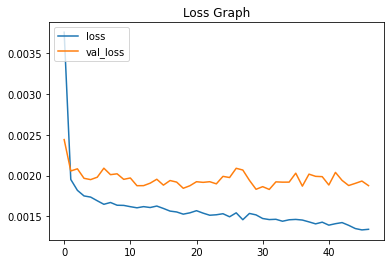

In [ ]:
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

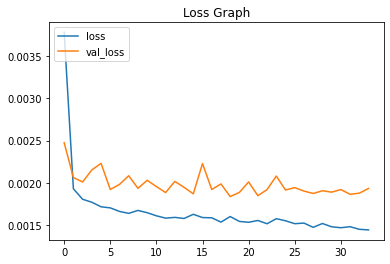

In [ ]:
plt.plot(train_history2.history["loss"])
plt.plot(train_history2.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [ ]:
x_val = x_val.reshape(-1,past,feature)
pre_price = regressor.predict(x_val)
pre_price = pre_price.reshape(-1,1)
pre_price = Yscaler.inverse_transform(pre_price)
y_val = Yscaler.inverse_transform(y_val)

In [ ]:
x_val.shape

(604, 15, 26)

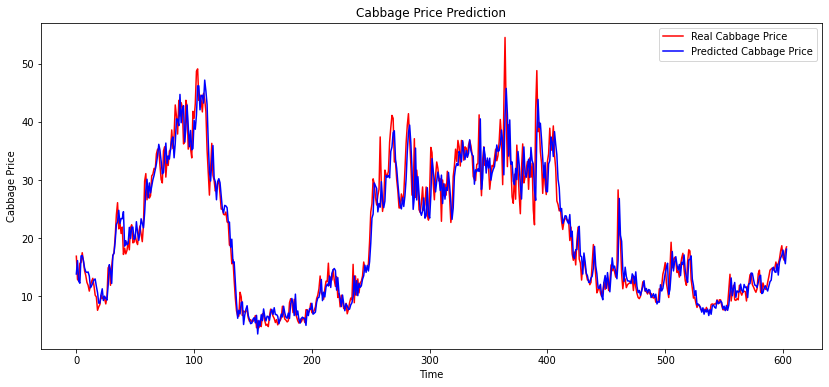

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(y_val, color = 'red', label = 'Real Cabbage Price')
plt.plot(pre_price, color = 'blue', label = 'Predicted Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

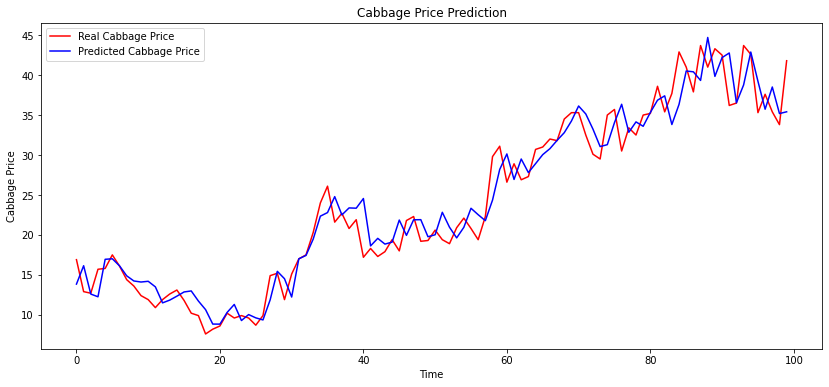

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(y_val[0:100], color = 'red', label = 'Real Cabbage Price')
plt.plot(pre_price[0:100], color = 'blue', label = 'Predicted Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

In [ ]:
# MSE & RMSE 計算
# sklearn.metrics.mean_squared_error(y_true, y_pred)
# sklearn.metrics.r2_score(y_true, y_pred)
from sklearn.metrics import mean_squared_error, r2_score
MSE = mean_squared_error(y_val, pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_val, pre_price)
print(f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")

MSE value : 8.591513238645176 
RMSE value : 2.931128321763681 
R2 score value : 0.9316879367318383


In [ ]:
# model1
gg = Xscaler.transform(gg.reshape(-1,feature))
gg = gg.reshape(-1,past,feature)
gg_pre_price = regressor.predict(gg)
gg_pre_price = Yscaler.inverse_transform(gg_pre_price)
# model2
gg2_pre_price = regressor2.predict(gg)
gg2_pre_price = Yscaler.inverse_transform(gg2_pre_price)
# model3
gg3_pre_price = regressor3.predict(gg)
gg3_pre_price = Yscaler.inverse_transform(gg3_pre_price)
# model4
gg4_pre_price = regressor4.predict(gg)
gg4_pre_price = Yscaler.inverse_transform(gg4_pre_price)
# model5
gg5_pre_price = regressor5.predict(gg)
gg5_pre_price = Yscaler.inverse_transform(gg5_pre_price)

In [ ]:
gg.shape

(308, 15, 26)

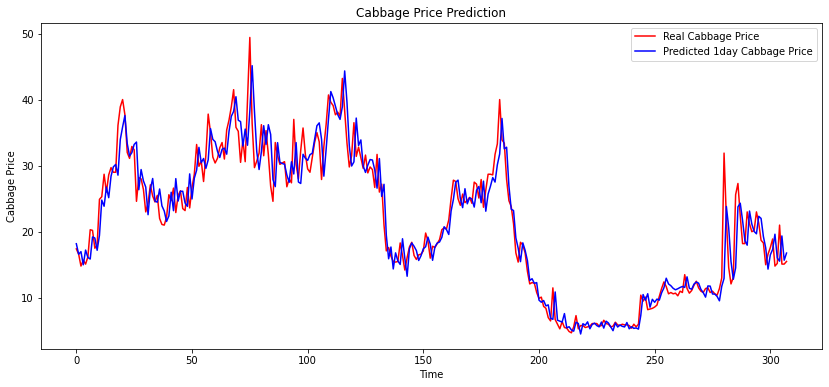

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(yy, color = 'red', label = 'Real Cabbage Price')
plt.plot(gg_pre_price, color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

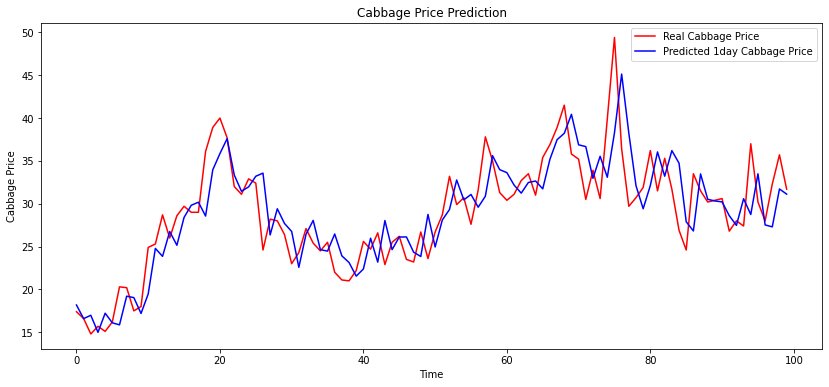

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(yy[0:100], color = 'red', label = 'Real Cabbage Price')
plt.plot(gg_pre_price[0:100], color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

In [ ]:
# MSE & RMSE 計算
# sklearn.metrics.mean_squared_error(y_true, y_pred)
# sklearn.metrics.r2_score(y_true, y_pred)
from sklearn.metrics import mean_squared_error, r2_score
MSE = mean_squared_error(yy, gg_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, gg_pre_price)
print(f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")

MSE value : 9.31292637210946 
RMSE value : 3.0517087626622335 
R2 score value : 0.9107146565754493


In [ ]:
RMSE = round(RMSE,2)
regressor.save(f"P={past}_F={day}_RMSE={RMSE}.h5")

In [ ]:
MSE = mean_squared_error(yy, gg2_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, gg2_pre_price)
print("Model-2", f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")
MSE = mean_squared_error(yy, gg3_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, gg3_pre_price)
print("Model-3", f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")
MSE = mean_squared_error(yy, gg4_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, gg4_pre_price)
print("Model-4", f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")
MSE = mean_squared_error(yy, gg5_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, gg5_pre_price)
print("Model-5", f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")

Model-2 MSE value : 9.47253853153373 
RMSE value : 3.077748939002941 
R2 score value : 0.9091844150703077
Model-3 MSE value : 9.416869240808323 
RMSE value : 3.068691780027496 
R2 score value : 0.9097181304184183
Model-4 MSE value : 9.389032015845304 
RMSE value : 3.064152740293033 
R2 score value : 0.9099850128237439
Model-5 MSE value : 9.666605664776986 
RMSE value : 3.109116540880542 
R2 score value : 0.9073238451541817


In [ ]:
ggall_pre_price = (gg_pre_price + gg2_pre_price + gg3_pre_price + gg4_pre_price + gg5_pre_price)/5
MSE = mean_squared_error(yy, ggall_pre_price)
RMSE = np.sqrt(MSE)
R2 = r2_score(yy, ggall_pre_price)
print(f"MSE value : {MSE}", f"\nRMSE value : {RMSE}", f"\nR2 score value : {R2}")

MSE value : 9.123940493885028 
RMSE value : 3.020586117607811 
R2 score value : 0.9125265112348173


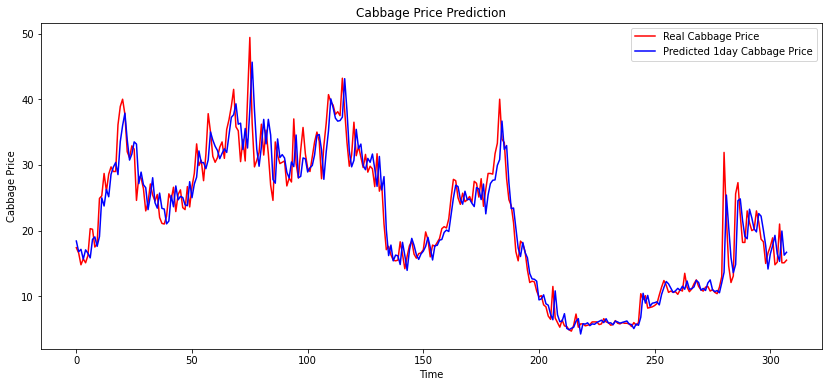

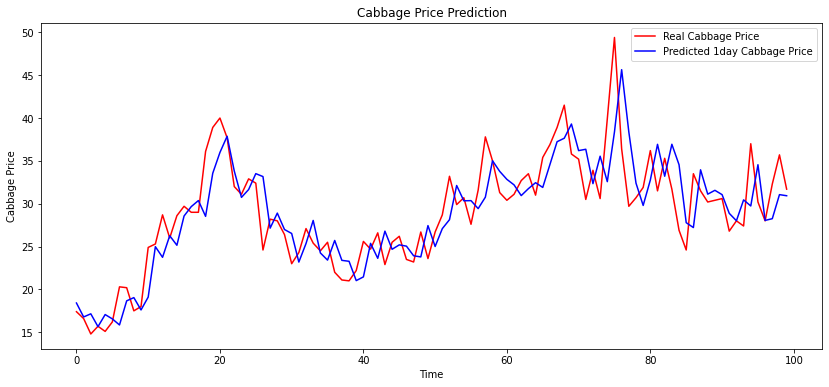

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(yy, color = 'red', label = 'Real Cabbage Price')
plt.plot(ggall_pre_price, color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(yy[0:100], color = 'red', label = 'Real Cabbage Price')
plt.plot(ggall_pre_price[0:100], color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

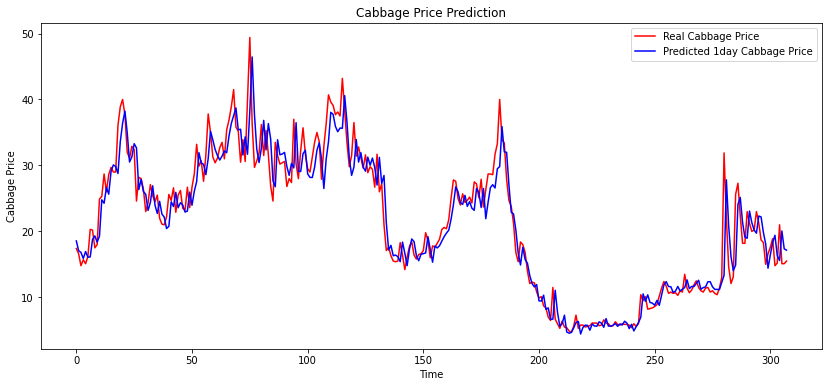

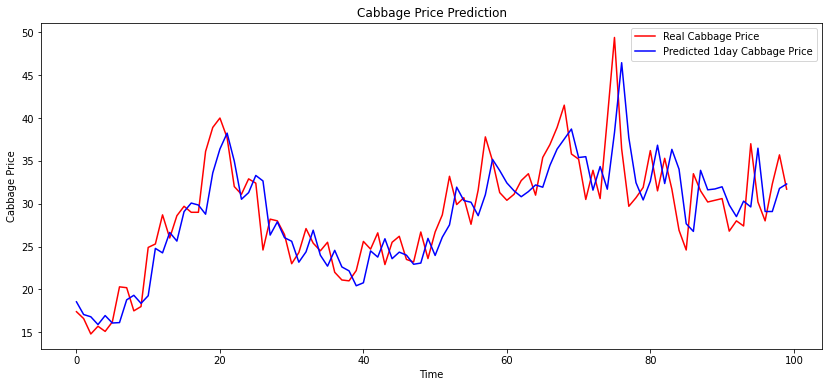

In [ ]:
# Visualising the results
plt.figure(figsize=(14,6))
plt.plot(yy, color = 'red', label = 'Real Cabbage Price')
plt.plot(gg5_pre_price, color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(yy[0:100], color = 'red', label = 'Real Cabbage Price')
plt.plot(gg5_pre_price[0:100], color = 'blue', label = f'Predicted {day}day Cabbage Price')
plt.title('Cabbage Price Prediction')
plt.xlabel('Time')
plt.ylabel('Cabbage Price')
plt.legend()
plt.show()